In [29]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pystan

# 1. Call Center Data
Data: waiting times for the 13th hour of a day in a call center<br>
Prior distribution: Gamma distribution with $\alpha = 1$ and $\beta = 0.25$<br>
Likelihood function: exponential with parameter $\lambda$<br>
Parameters: rate $\lambda$<br>
Posterior: Gamma distribution over $\lambda$<br>

In [30]:
## import the dataset (code from call_center_solution.ipynb)
waiting_times_day = np.loadtxt('call_center.csv')

# Split the data into 24 separate series, one for each hour of the day
current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)
    
# use just the 13th hour of the day
waiting_times_hour = waiting_times_per_hour[13]

In [31]:
call_center_data = {
    '13': {
        'alpha': 1,  # fixed prior hyperparameters for the
        'beta': 0.25,   # gamma distribution
        'num_calls': len(waiting_times_hour),  # number of calls coming in
        'waiting_times': waiting_times_hour} # data set on waiting times
    }

In [49]:
calls_stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_calls;  // number of calls
    real<lower=0> waiting_times[num_calls];  // waiting times
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// All unknown quantities, in this case the waiting time lambda
parameters {
    real lambd;  // rate lambda for the exponential
}

// The model block contains all probability distributions in the model.
model {
    lambd ~ gamma(alpha, beta);  // prior over lambda
    for(i in 1:num_calls) {
        waiting_times[i] ~ exponential(lambd);  // likelihood function
    }
}

"""

In [50]:
calls_stan_model = pystan.StanModel(model_code=calls_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_50fe82232f7cd8b2736c8b3bf1959587 NOW.


In [55]:
calls_stan_results = calls_stan_model.sampling(data=call_center_data['13'])
print(calls_stan_results.stansummary(pars=['lambd'], probs=[0.01, 0.5, 0.99]))

Inference for Stan model: anon_model_50fe82232f7cd8b2736c8b3bf1959587.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd     1%    50%    99%  n_eff   Rhat
lambd   6.35  8.9e-3   0.33   5.62   6.35   7.15   1346    1.0

Samples were drawn using NUTS at Wed Oct  7 23:14:43 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 98% confidence interval for lambda: [5.62041666 7.14781511]


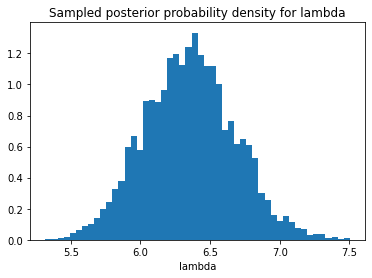

In [60]:
posterior_calls_samples = calls_stan_results.extract()
plt.hist(posterior_calls_samples['lambd'], bins=50, density=True)
plt.xlabel("lambda")
plt.title('Sampled posterior probability density for lambda')
print(
    "Posterior 98% confidence interval for lambda:",
    np.percentile(posterior_calls_samples['lambd'], [1, 99]))
plt.show()

# 2. Normal likelihood with normal-inverse-gamma prior

In [65]:
#define dataset 
raw_norm_inv_gamma_data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
norm_inv_gamma_data = {
        'mu': 0,  # prior mean centered at 0
        'nu': 0.054,   # nu indicates the uncertainty of the prior mean
        'alpha' : 1.12, # alpha and beta govern the marginal prior over the variance
        'beta' : 0.4,
        'data_length': len(raw_norm_inv_gamma_data),  # number of data points
        'norm_data': raw_norm_inv_gamma_data} # data set

In [70]:
norm_inv_gamma_stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> data_length;  // number of data points
    real norm_data[data_length];  // data points
    real mu; // fixed prior hyperparameter
    real nu; // fixed prior hyperparameter
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// All unknown quantities, in this case the mean and standard deviation of the data
parameters {
    real x;  // mean of the data
    real<lower=0> sigma2; // variance of the data
}

// The model block contains all probability distributions in the model.
model {
    x ~ inv_gamma(alpha, beta);  // prior over mean
    sigma2 ~ normal(mu,sqrt(sigma2/nu)); //prior over variance 
    for(i in 1:data_length) {
        norm_data[i] ~ normal(x,sigma2);  // likelihood function
    }
}

"""

In [71]:
norm_inv_gamma_stan_model = pystan.StanModel(model_code=norm_inv_gamma_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7a171de86991541fb4aeae3726cd40f6 NOW.


In [72]:
norm_inv_gamma_stan_results = norm_inv_gamma_stan_model.sampling(data=norm_inv_gamma_data)
print(norm_inv_gamma_stan_results.stansummary(pars=['x','sigma2'], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_7a171de86991541fb4aeae3726cd40f6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
x        3.05  2.5e-3   0.14   2.79   3.05   3.31   2911    1.0
sigma2   1.92  1.8e-3    0.1   1.74   1.91   2.12   2997    1.0

Samples were drawn using NUTS at Thu Oct  8 00:01:56 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
posterior_norm_inv_gamma_samples = norm_inv_gamma_stan_results.extract(10)

plt.hist(posterior_calls_samples['lambd'], bins=50, density=True)
plt.xlabel("lambda")
plt.title('Sampled posterior probability density for lambda')
print(
    "Posterior 98% confidence interval for lambda:",
    np.percentile(posterior_calls_samples['lambd'], [1, 99]))
plt.show()

# 3. Log-normal HRTEM data